In [123]:
from bs4 import BeautifulSoup # to parse html
import pandas as pd

In [124]:
bigfoot_file = 'data/bigfoot_first100records.json'

with open(bigfoot_file) as f:
    raw_df = pd.read_json(f, lines=True)

In [125]:
raw_df.head()

,_id,url,html,time
0,{'$oid': '5939abbd2acdf6607095366c'},show_report.asp?id=13038,"\r\n<!doctype html public ""-//w3c//dtd html 4....",Thu Jun 8 19:55:40 2017
1,{'$oid': '5939abbd2acdf6607095366d'},show_report.asp?id=8792,"\r\n<!doctype html public ""-//w3c//dtd html 4....",Thu Jun 8 19:55:41 2017
2,{'$oid': '5939abbd2acdf6607095366e'},show_report.asp?id=1255,"\r\n<!doctype html public ""-//w3c//dtd html 4....",Thu Jun 8 19:55:41 2017
3,{'$oid': '5939abbd2acdf6607095366f'},show_report.asp?id=11616,"\r\n<!doctype html public ""-//w3c//dtd html 4....",Thu Jun 8 19:55:41 2017
4,{'$oid': '5939abbe2acdf66070953670'},show_report.asp?id=637,"\r\n<!doctype html public ""-//w3c//dtd html 4....",Thu Jun 8 19:55:42 2017


In [130]:
[x.text for x in soup.findAll('span')[0:5]]

['Geographical Index > United States > Alaska > Valdez-Chitina-Whittier County > Report # 1261\xa0',
 'Report # 1261',
 '(Class A)',
 'Submitted  by Henner Fahrenbach on Wednesday,\xa0January\xa01,\xa01997.',
 'Fisherman views a sasquatch through binoculars at a distance of 1000 feet']

In [131]:
def build_header(str_lst):
    result = {}
    geographic = [x.strip() for x in str_lst[0].split('>')]
    geo_dict = {}
    geo_dict['region'] = geographic[1]
    geo_dict['state'] = geographic[2]
    geo_dict['detail'] = geographic[3]
    report = geographic[4]
    geo_dict['report'] = report.split(' ')[-1]
    geo_dict['report_class'] = str_lst[2]
    return geo_dict

In [132]:
build_header([x.text for x in soup.findAll('span')[0:5]])

{'region': 'United States',
 'state': 'Alaska',
 'detail': 'Valdez-Chitina-Whittier County',
 'report': '1261',
 'report_class': '(Class A)'}

In [133]:
def build_details(str_lst):
    
    # empty list to store return key value pairs
    result = {}
    
    # flag to alter the way we build keys
    process_diff = False
    
    # empty array to store extra information if process_diff flag is True
    extra = []
    for i, x in enumerate(str_lst):
        # splits each line into a key, value string pair
        first, *second = x.split(':')
        
        if not first.isupper():    
            # checks if key isn't CAPS, if not we process the rest of the html differently
            process_diff = True
            
        if not process_diff:
            # we join the second part in case there exists a colon ":" inside the raw text
            result[first] = (' '.join(second)).strip()
            
        else:
            # append each extra line to a general array
            extra.append(x)
    
    # combine all extra values into a single long string
    result['extra'] = ' '.join(extra)
    return result

In [134]:
soup = BeautifulSoup(raw_df.html[19])

build_details([x.text for x in soup.find_all('p')])

{'YEAR': "Early 1990's",
 'SEASON': 'Fall',
 'STATE': 'Alaska',
 'COUNTY': 'Valdez-Chitina-Whittier County',
 'LOCATION DETAILS': 'East side of Prince William Sound',
 'OBSERVED': 'Ed L. was salmon fishing with a companion in Prince William Sound. After anchoring off shore, his companion took a small boat up a river to check on the state of the salmon run. As the day wore on toward evening and he didn\'t come back at the expected time, Ed scanned upriver and across the adjacent land with binoculars. There he saw a sasquatch walking across the tundra, with long, smooth steps and with dark hair flowing from its shoulders, bouncing behind "like a cape" at every step. The sasquatch paid no attention to the boat (distance about 1,000\').',
 'OTHER WITNESSES': 'On a commercial fishing boat at anchor at the mouth of one of the rivers discharging into the bay.',
 'TIME AND CONDITIONS': "Early Fall, in the early 1990's.",
 'extra': 'Follow-up investigation report by BFRO Investigator Dr. Wolf H

In [135]:
def process_one(row):
    soup = BeautifulSoup(row)
    details = build_details([x.text for x in soup.find_all('p')])
    header = build_header([x.text for x in soup.find_all('span')[0:5]])
    joined = {}
    joined.update(details)
    joined.update(header)
    return joined
    

In [138]:
processed = []

for i, row in enumerate(raw_df.html):
    try:
        processed.append(process_one(row))
    except Exception as e:
        print(f'row: {i}', e)

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  5.,  5., 28., 59.]),
 array([ 6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. , 16.5, 18. , 19.5, 21. ]),
 <a list of 10 Patch objects>)

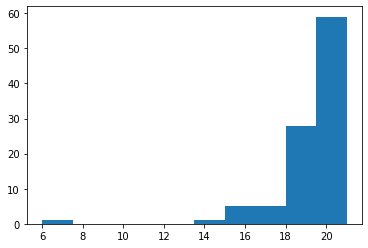

In [142]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist([len(x.keys()) for x in processed])

In [143]:
for x in processed:
    if len(x.keys()) < 14:
        print(x)

{'extra': 'Media Article # 576\n Friday,\xa0April\xa015,\xa01938 Hairy Wild Man Sought In Swamp The Oshkosh Northwestern Anniston, Ala. - (UP) - A wild man who runs on all fours, chases dogs and frightens farmers is being sought in a dense swamp in the Choccolocco valley.  Sheriff W. P. cotton led a posse in search of the strange beast which, farmers insisted, was accompanied by a woman and a child - both as savage in appearance and actions as the man.  Rex Biddle, a farmer, told Sheriff Cotton that the man approached his home walking on all fours in the manner of an ape.  "He was about five feet tall, and had hair all over his body," Biddle said.  "He was unclothed.  Despite his beastlike appearance, his nose and other features indicated he was human."  Biddle said he reached for his gun but didn\'t shoot because "I did know whether that would be legal."  Roy Storey, annother farmer, said the creature followed him for a time and then "dropped to all fours and chased my pet dog into th

In [140]:
df = pd.DataFrame(processed)

In [141]:
df.head()

,YEAR,SEASON,MONTH,STATE,COUNTY,LOCATION DETAILS,NEAREST TOWN,NEAREST ROAD,OBSERVED,ALSO NOTICED,...,OTHER STORIES,TIME AND CONDITIONS,ENVIRONMENT,extra,region,state,detail,report,report_class,DATE
0,2004,Winter,February,Alaska,Anchorage County,Up near powerline clearings east of Potter Mar...,Anchorage / Hillside,No real roads in the area,I and two of my friends were bored one night s...,"Some tracks in the snow, and a clearing in the...",...,I have not heard of any other incidents in Anc...,Middle of the night. The only light was the he...,"In the middle of the woods, in a clearing cove...",Follow-up investigation report by BFRO Investi...,United States,Alaska,Anchorage County,13038,(Class A),NaN
1,2003,Winter,December,Alaska,Anchorage County,"Few houses on the way, a power relay station. ...",Anchorage,Dowling,"Me and a couple of friends had been bored, whe...","We smelled of colonge and after shave, and one...",...,no,"Started at 11, ended at about 3-3 30. Weather ...","A pine forest, with a bog or swamp on the righ...",Follow-up investigation report by BFRO Investi...,United States,Alaska,Anchorage County,8792,(Class B),Friday night
2,1998,Fall,September,Alaska,Bethel County,"45 miles by air west of Lake Iliamna, Alaska i...",NaN,NaN,My hunting buddy and I were sitting on a ridge...,nothing unusual,...,NaN,NaN,Call Iliamna Air taxi for lat & Long of Long L...,,United States,Alaska,Bethel County,1255,(Class B),3
3,2004,Summer,July,Alaska,Bristol Bay County,"Approximately 95 miles east of Egegik, Alaska....",Egegik,NaN,"To whom it may concern, I am a commercial fish...",Just these foot prints and how obvious it was ...,...,"I've only heard of one other story, from an ol...","Approximately 12 30 pm, partially coudy/sunny.","Lake front,creek spit, gravel and sand, alder ...",Follow-up investigation report by BFRO Investi...,United States,Alaska,Bristol Bay County,11616,(Class B),20
4,2000,Summer,June,Alaska,Cordova-McCarthy County,"On the main trail toward the glacier, before t...","Kennikot, Alaska",not sure,My hiking partner and I arrived late to the Ke...,I did hear what appeared to be grunting in the...,...,None,About 12 00 Midnight / full moon / clear / dim...,This sighting was located at approximately 1 t...,Follow-up investigation report: Summary of com...,United States,Alaska,Cordova-McCarthy County,637,(Class A),16
